In [1]:
import os
import sys
import glob

import torch
from torchvision.transforms import Compose, Resize, ToTensor, PILToTensor, ConvertImageDtype

ST_DIR = os.getcwd()
EXP_DIR = os.path.dirname(ST_DIR)
ROOT_DIR = os.path.dirname(EXP_DIR)
sys.path.append(ROOT_DIR)

from core.trainer import BinaryClassifierTrainer
from experiments.st.datasets import STDataSet  
from experiments.st.data_model import STImages
from experiments.st._paths import DataPaths

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import mlflow
model = torch.load(os.path.join(ROOT_DIR, "data", "model.pth"), map_location=torch.device(DEVICE))
# model = mlflow.pytorch.load_model("file:///home/oem/repositories/mlflow_artifact/3/70d34166b6f9422da3ea301aee89e6d1/artifacts/model")
# model = mlflow.pytorch.load_model("file:///home/oem/repositories/mlflow_artifact/3/cabcd6e6865148f59464bfb408f53b24/artifacts/model")

### Online

In [12]:
from PIL import Image
import numpy as np
class OnlineSTDataSet(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None, device: str = "cpu", **kwargs):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.device = device
        self.kwargs = kwargs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert("RGB")

        if self.transform:
            return (
                self.transform(image).to(self.device),
                torch.tensor([self.labels[idx]]).to(self.device).float(),
            )

        return (
            torch.tensor(np.array(image)).to(self.device),
            torch.tensor([self.labels[idx]]).to(self.device).float(),
        )


In [13]:
trainer = BinaryClassifierTrainer(model, loss=torch.nn.functional.binary_cross_entropy_with_logits)
data_paths = DataPaths(os.path.join(ROOT_DIR, "data"))
st_images = STImages(
    s_image_paths=glob.glob(str(data_paths.online.s / "*")),
    t_image_paths=glob.glob(str(data_paths.online.t / "*")),
)
transform = Compose(
        [PILToTensor(), Resize((512, 512)), ConvertImageDtype(torch.float)]
    )
st_dataset = OnlineSTDataSet(
    st_images.image_paths,
    st_images.labels,
    transform,
    device=DEVICE,
)
ge_loss, ge_metris = trainer.run_epoch(
    phase="test", 
    epoch=1, 
    dataloader=torch.utils.data.DataLoader(
        st_dataset,
        batch_size=1,
        shuffle=False,
    ),
)

 |################################| test | EPOCH 1: [17/18] | eta:1 | total_loss: 0.48382 | accuracy: 0.83333 | auroc: 0.90909 | prauc: 0.95823


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic (PRAUC)'}, xlabel='Recall', ylabel='Precision'>)

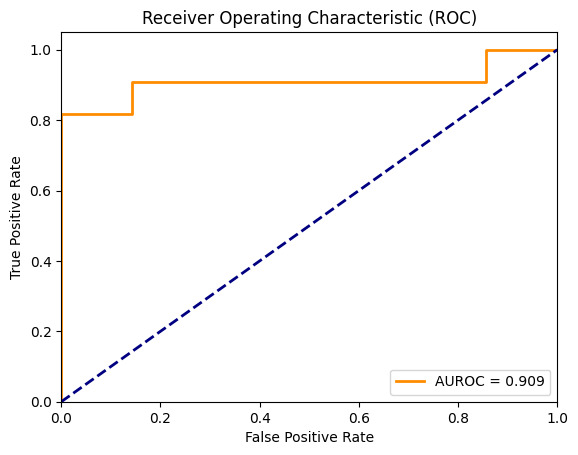

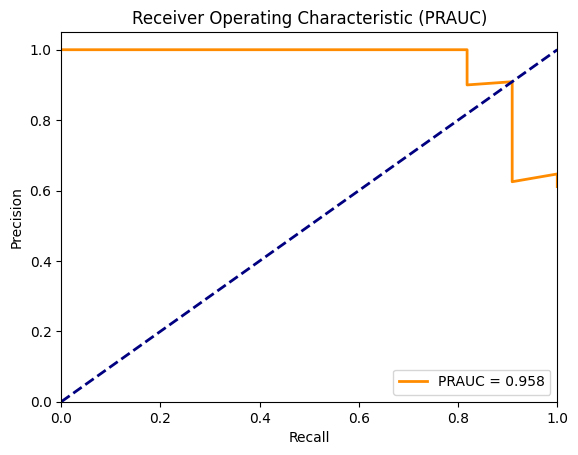

In [14]:
from core.metics import plot_auroc, plot_prauc

plot_auroc(ge_metris.labels, ge_metris.probs)
plot_prauc(ge_metris.labels, ge_metris.probs)